In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
#from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [3]:
df = pd.read_csv('Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('Corona_NLP_test.csv')

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
#convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/Users/karen/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/karen/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '17-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/karen/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '18-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/karen/.local/lib/python3.8/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '19-03-2020' in DD/MM/YYYY format. Prov

## EDA

In [7]:
#drop duplicates
df.drop_duplicates(subset='OriginalTweet',inplace=True)
df.info()
#no duplicates found

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.2+ MB


In [8]:
#count by date
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

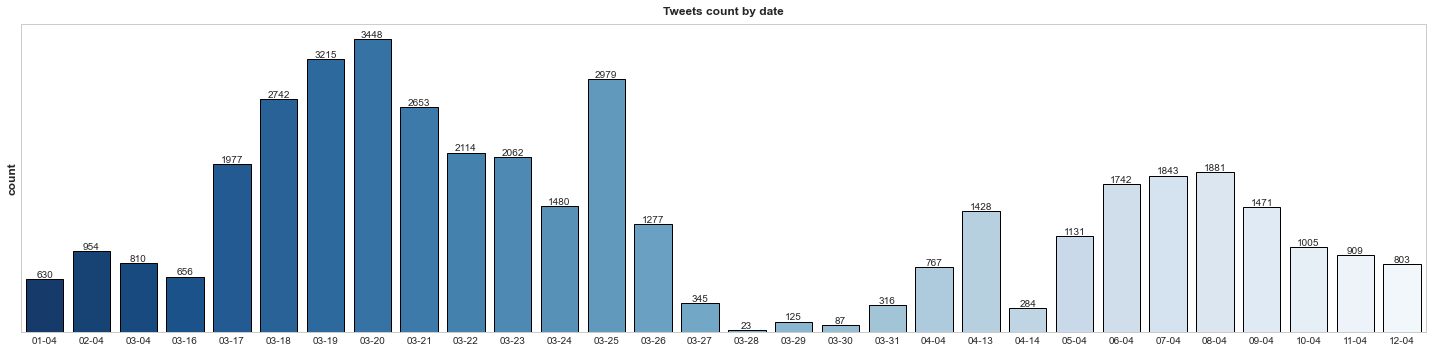

In [9]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Among the days with tweets, most of them are made around the end of March: from 18th of Match to the 26th of March.

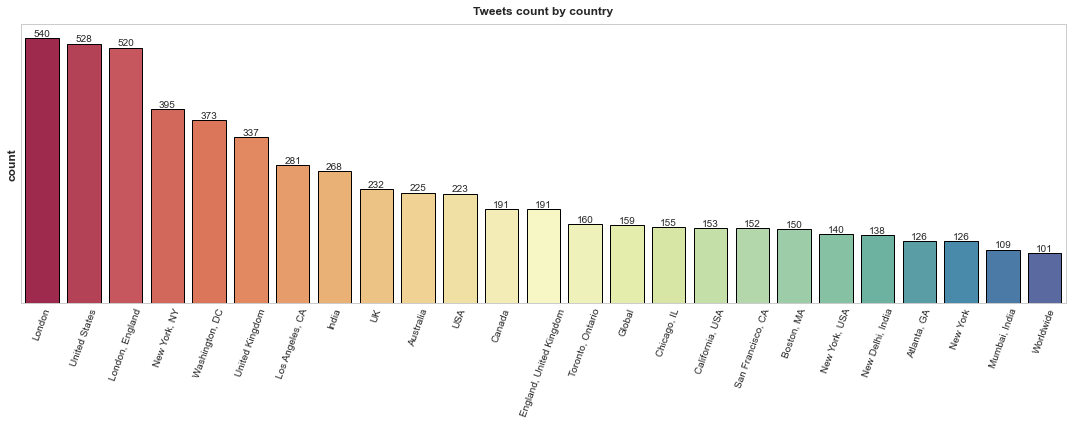

In [10]:
#COUNT BY country
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

plt.figure(figsize=(15,6))
ax = sns.barplot(x='index', y='counts', data=tweets_per_country,edgecolor = 'black',ci=False, palette='Spectral')
plt.title('Tweets count by country')
plt.xticks(rotation=70)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## text cleaning

In [11]:
df = df[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [12]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS
def text_cleaning(text):
    #Clean emojis from text
    def get_emoji_regexp():
        # Sort emoji by length to make sure multi-character emojis are
        # matched first
        emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
        pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
        return re.compile(pattern)

    re.sub(get_emoji_regexp(), r"", text) #remove emoji

    #Remove punctuations, links, mentions and \r\n new line characters
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)


    #clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence

    # #Filter special characters such as & and $ present in some words
    # sent = []
    # for word in a.split(' '):
    #     if ('$' in word) | ('&' in word):
    #         sent.append('')
    #     else:
    #         sent.append(word)

    # remove multiple spaces
    return re.sub("\s\s+" , " ", new_tweet2)

In [13]:
df['text_clean'] = df['OriginalTweet'].apply(text_cleaning)

In [14]:
df_test['text_clean'] = df_test['OriginalTweet'].apply(text_cleaning)

## Class Balancing by RandomOverSampler

In [15]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [16]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [17]:
df['Sentiment'].value_counts()

2    18046
0    15398
1     7713
Name: Sentiment, dtype: int64

In [18]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

## BERT Model

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []
for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [23]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [28]:
# train, test split
X = train_os['text_clean'].values
y = train_os['Sentiment'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

from keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

#apply the tokenizer function to the train, validation and test sets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [25]:
#use pre-trained bert model
#bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

model = create_model(bert_model, MAX_LEN)
model.summary()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-10-12 17:53:57.634466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoi

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
#fine tuning bert transformer
tf.config.experimental_run_functions_eagerly(True)
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, 
                        validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32)

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))